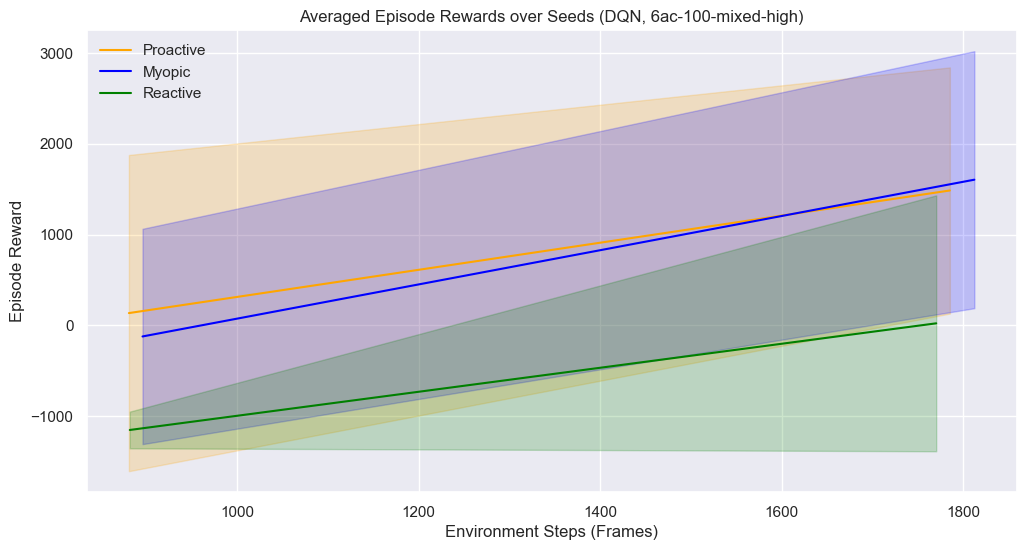

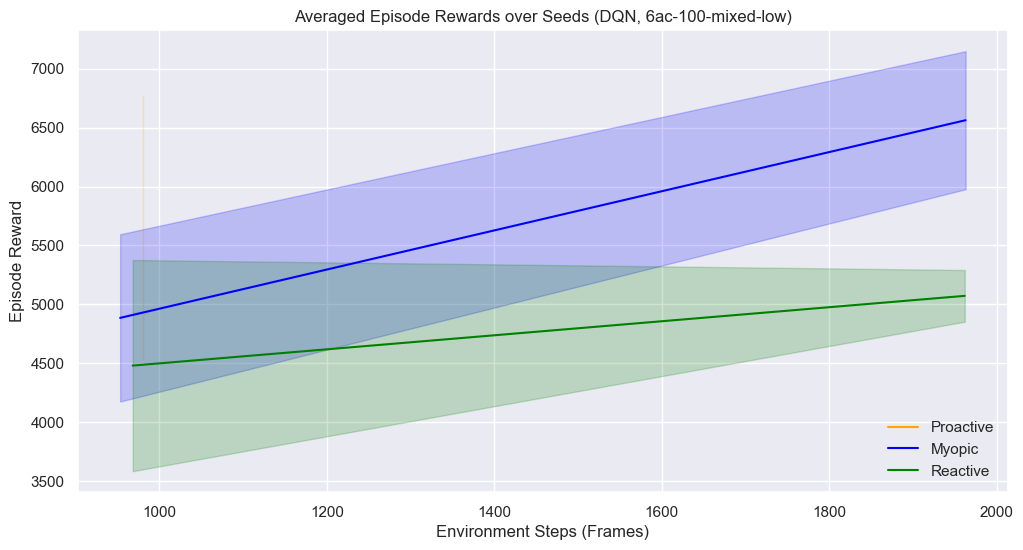

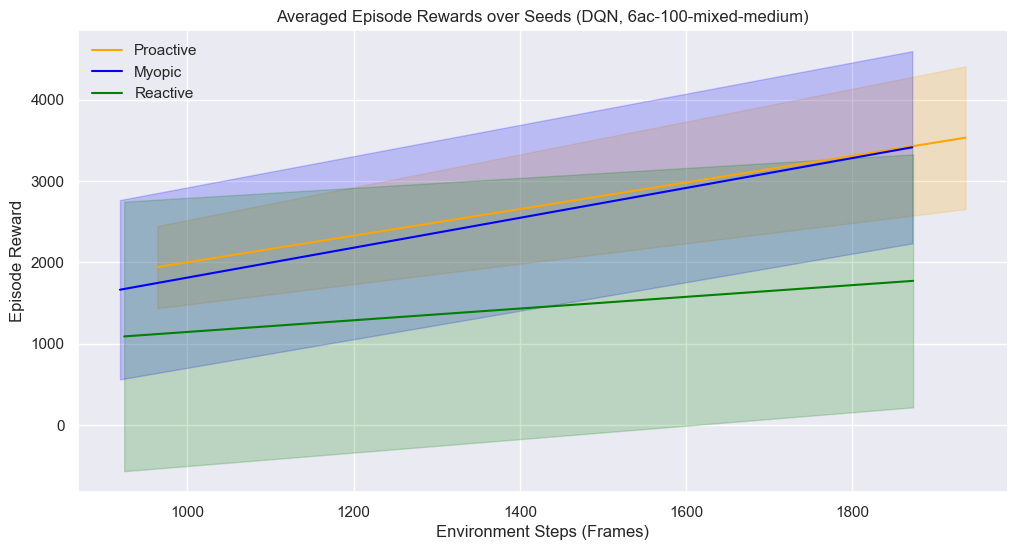

Done plotting all scenarios.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_results_folder = "../abc-big-run"  # folder containing scenario subfolders

# A simple smoothing function (optional)
def smooth(data, window=10):
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Scan the base folder for scenario subdirectories
scenario_folders = [
    f for f in os.listdir(base_results_folder) 
    if os.path.isdir(os.path.join(base_results_folder, f))
]

sns.set(style="darkgrid")

for scenario in scenario_folders:
    # Path to the numpy folder inside this scenario
    numpy_dir = os.path.join(base_results_folder, scenario, "numpy")
    if not os.path.exists(numpy_dir):
        # If there's no numpy folder, skip this scenario
        continue
    
    # Load the arrays
    try:
        all_myopic_runs = np.load(os.path.join(numpy_dir, "all_myopic_runs.npy"))
        all_myopic_steps_runs = np.load(os.path.join(numpy_dir, "all_myopic_steps_runs.npy"))
        all_proactive_runs = np.load(os.path.join(numpy_dir, "all_proactive_runs.npy"))
        all_proactive_steps_runs = np.load(os.path.join(numpy_dir, "all_proactive_steps_runs.npy"))
        all_reactive_runs = np.load(os.path.join(numpy_dir, "all_reactive_runs.npy"))
        all_reactive_steps_runs = np.load(os.path.join(numpy_dir, "all_reactive_steps_runs.npy"))
        
        # Test rewards might not exist if cross_val_flag was False
        test_rewards_myopic_path = os.path.join(numpy_dir, "all_test_rewards_myopic.npy")
        test_rewards_proactive_path = os.path.join(numpy_dir, "all_test_rewards_proactive.npy")
        test_rewards_reactive_path = os.path.join(numpy_dir, "all_test_rewards_reactive.npy")

        test_rewards_myopic = np.load(test_rewards_myopic_path) if os.path.exists(test_rewards_myopic_path) else None
        test_rewards_proactive = np.load(test_rewards_proactive_path) if os.path.exists(test_rewards_proactive_path) else None
        test_rewards_reactive = np.load(test_rewards_reactive_path) if os.path.exists(test_rewards_reactive_path) else None

    except FileNotFoundError as e:
        print(f"Missing files in {numpy_dir}, skipping scenario '{scenario}'. Error: {e}")
        continue

    # Compute means and std
    myopic_mean = all_myopic_runs.mean(axis=0)
    myopic_std = all_myopic_runs.std(axis=0)
    proactive_mean = all_proactive_runs.mean(axis=0)
    proactive_std = all_proactive_runs.std(axis=0)
    reactive_mean = all_reactive_runs.mean(axis=0)
    reactive_std = all_reactive_runs.std(axis=0)

    myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)
    proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)
    reactive_steps_mean = all_reactive_steps_runs.mean(axis=0).astype(int)

    # Smooth data for plotting (optional)
    smooth_window = 1
    myopic_mean_sm = smooth(myopic_mean, smooth_window)
    myopic_std_sm = smooth(myopic_std, smooth_window)
    myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

    proactive_mean_sm = smooth(proactive_mean, smooth_window)
    proactive_std_sm = smooth(proactive_std, smooth_window)
    proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

    reactive_mean_sm = smooth(reactive_mean, smooth_window)
    reactive_std_sm = smooth(reactive_std, smooth_window)
    reactive_steps_sm = reactive_steps_mean[:len(reactive_mean_sm)]

    # Plot averaged rewards over steps for this scenario
    plt.figure(figsize=(12,6))
    plt.plot(proactive_steps_sm, proactive_mean_sm, label="Proactive", color='orange')
    plt.fill_between(proactive_steps_sm, 
                     proactive_mean_sm - proactive_std_sm, 
                     proactive_mean_sm + proactive_std_sm, 
                     alpha=0.2, color='orange')
    plt.plot(myopic_steps_sm, myopic_mean_sm, label="Myopic", color='blue')
    plt.fill_between(myopic_steps_sm, 
                     myopic_mean_sm - myopic_std_sm, 
                     myopic_mean_sm + myopic_std_sm, 
                     alpha=0.2, color='blue')

    plt.plot(reactive_steps_sm, reactive_mean_sm, label="Reactive", color='green')
    plt.fill_between(reactive_steps_sm, 
                     reactive_mean_sm - reactive_std_sm, 
                     reactive_mean_sm + reactive_std_sm, 
                     alpha=0.2, color='green')

    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    plt.title(f"Averaged Episode Rewards over Seeds (DQN, {scenario})")
    plt.legend(frameon=False)
    plt.grid(True)
    plt.show()

    # # If test rewards exist, plot them as well
    # if test_rewards_myopic is not None and len(test_rewards_myopic) > 0:
    #     # Just plot the first seed's test rewards for demonstration
    #     plt.figure(figsize=(12,6))
    #     plt.plot(test_rewards_myopic[0], label="Myopic", color='blue')
    #     plt.plot(test_rewards_proactive[0], label="Proactive", color='orange')
    #     plt.plot(test_rewards_reactive[0], label="Reactive", color='green')
    #     plt.xlabel("Episode")
    #     plt.ylabel("Test Reward")
    #     plt.title(f"Test Rewards over Episodes (DQN, {scenario})")
    #     plt.legend(frameon=False)
    #     plt.grid(True)
    #     plt.show()

print("Done plotting all scenarios.")
